# Clustering Example


The goal of this script is to illustrate k-means clustering on bias and variance
on measurements with time dependent noise. Based on these two features, different noise regimes are identified (e.g. meteorological situations for total station measurements).


For this, do the following:

    1. Definitions and imports
    2. Simulate noise (Temperature T and Pressure P)
    3. Simulate time series of measurements
    4. Initialize the clustering
    5. Execute k-means clustering
    6. Plots and illustrations

The following entries may be changed to explore the script:

    * var_T_P             : The variance of temperature and pressure used to simulate the measurements.
                          Increasing it increases the long and short - term variability.
    * var_change_induced  : Additional variance of measurements occuring during periods of change.
                          Increase to make measurements during transition periods (morning, evening) more uncertain.
    * n_clusters          : The numbers of clusters to be found by the k-means clustering algorithm
                                        
This script is given out as part of the Machine Learning Tutorial during IV2020, Munich. Please consult the slides for some background information regarding motivation and a possible physical setup for this toy example.

Written by Jemil Butt, Zan Gojcic, ETH Zurich.

# 1. Definitions and imports ------------------------------------------------

We suppose that the total station executes $10$ measurements per hour leading to $n_{timesteps}=240$ measurements per day. At each of the times of measurement $t_k, k=1, ... ,n_{timesteps}$ the meteorological conditions (in form of temperature and pressure) affect the measurements leading random and systematic deviations in the measured distances. Timeseries data will be generated for $n_{episodes}$ different days.

Define the variabilities of $T$ and $P$ by specifying their variances $\sigma_T^2, \sigma_P^2$. Additional volatility occurs during periods of significant drifts of temperature or pressure. The size of this effect is quantified by $\sigma^2_{change ~induced}$. The amount of recognizably different situations suspected to be found in the data can be specified by the user by changing the value of $n_{clusters}$.

In [2]:

# 1.1 Import numerical and plotting libraries
import numpy as np
import copy
import matplotlib.pyplot as plt
from numpy import matlib as mb


# 1.2 Define the number of datapoints (measurements per day) gathered and the number of episodes (days)
n_timesteps=240                             # Needs to be divisible by 20
n_episodes=20

time=np.linspace(0,1,n_timesteps)
time_plot=np.linspace(0,24,n_timesteps)

# 1.3 Parameters for simulation and clustering    # The following parameters may be changed to explore the method
var_T_P=np.array([0.5,5])                         # Variance of temperature [C], pressure [hPA]. Increase for higher long
                                                  # long term volatility
var_change_induced=5                              # Increase for higher noise during periods of changes
n_clusters=3                                      # Numbers of clusters to be discovered

print('Packages imported. The parameters for simulation and clustering have been defined and are now \
ready for later use.')


Packages imported. The parameters for simulation and clustering have been defined and are now ready for later use.


#2. Simulate noise (Temperature T and Pressure P) --------------------------

Simulate the evolution of temperature $T$ and pressure $P$ over $n_{episodes}$ different days. For this, assume both quantities to vary randomly in time but in an autocorrelated way - each realization is a random walk starting and ending at 0. The expected value of the temperature $T$ peaks during noon and has a minimum during the night whereas there are no time dependent drifts simulated for the evolution of the pressure $P$. $T$ and $P$ are more volatile during the morning and the evening reflected in higher variances during those times. Some simulations of temperature and pressure can be seen in the images below.

Example temperature $\hspace{3cm}$ All temperature evolutions $\hspace{3cm}$ Example pressure $\hspace{3cm}$ All pressure evolutions 
![alt text](https://drive.google.com/uc?id=1KV49KtbKMieN7EBJfPV1xqb21QRQLSI2)

In [3]:

# 2.1 Define the mean vectors of the simulations

bump_fun=np.concatenate((np.linspace(0,0,int(n_timesteps/6)),np.linspace(0,1,int(n_timesteps/6)),\
                         np.linspace(1,1,int(n_timesteps/3)),np.linspace(1,0,int(n_timesteps/6)),np.linspace(0,0,int(n_timesteps/6))))

mean_vector_T=10*np.ones(n_timesteps)+3*bump_fun
mean_vector_P=1013.5*np.ones(n_timesteps)

# 2.2 Define the covariance matrices of the simulations 
Cov_mat_T=np.zeros([n_timesteps,n_timesteps])
Cov_mat_P=np.zeros([n_timesteps,n_timesteps])

for i in range(n_timesteps):
    for j in range(n_timesteps):
        Cov_mat_T[i,j]=var_T_P[0]*(min(time[i],time[j])-time[i]*time[j])
        Cov_mat_P[i,j]=var_T_P[1]*(min(time[i],time[j])-time[i]*time[j])

# Add change dependent noise onto the Brownian bridge covariance
Change_induced_noise=np.diag(var_change_induced*np.power(mean_vector_T-np.roll(mean_vector_T,1),2))
Cov_mat_T=Cov_mat_T+Change_induced_noise

# 2.3 Execute the simulations of temperature and Pressure
T_over_time=np.zeros([n_timesteps,n_episodes])
P_over_time=np.zeros([n_timesteps,n_episodes])

for k in range(n_episodes):
    T_over_time[:,k]=np.random.multivariate_normal(mean_vector_T,Cov_mat_T)
    P_over_time[:,k]=np.random.multivariate_normal(mean_vector_P,Cov_mat_P)

print('Covariance matrices have been constructed. Simulations were carried out by sampling from \
multivariate normal distributions.')
    

Covariance matrices have been constructed. Simulations were carried out by sampling from multivariate normal distributions.


# 3.Simulate time series of measurements ------------------------------------

Use the timeseries of $T$ and $P$ to calculate the bias in the distance measurements $d$ by using the standard equation

$$ \Delta d = [\Delta T -0.3 \Delta P] d  $$

to calculate timeseries of distance biases $\Delta d (t)$ for each day. From $\Delta d(t)$ extract timeseries of biases $\mu(t)$ and variances $\sigma^2(t)$.
They will act as the features that will be clustered later on. Each feature vector $x_k=(\mu(t_k),\sigma^2(t_k)$ is a point in a two-dimensional plane and the goal of the clustering is to identify regimes with similar stochastic properties. The features are centered and whitened to ensure that the Euclidean distance between them is a meaningful measure of closeness.

In [4]:
# 3.1 Process temperature and pressure to generate changes of distance measurements
T_0=T_over_time[0]
P_0=P_over_time[0]

Delta_T=T_over_time-T_0
Delta_P=P_over_time-P_0
Delta_d_measured=-(-Delta_T+0.3*Delta_P)*0.1

# 3.2 Calculate estimates of biases and variances as features for clustering
n_aggregation=20
bias=[]
variance=[]
time_datapoint=[]

for k in range(n_episodes):
    Delta_d=np.reshape(Delta_d_measured[:,k],[int(n_timesteps/n_aggregation),n_aggregation])
    Delta_d=Delta_d.T
    bias=np.append(bias,np.mean(Delta_d,0))
    variance=np.append(variance,np.std(Delta_d,0))
    time_datapoint=np.append(time_datapoint,np.mean(np.reshape(time_plot,[int(n_timesteps/n_aggregation),n_aggregation]),1))
     
bv_mat=np.vstack([bias,variance])

# 3.3 Whiten the data
n_datapoints=len(bias)
bv_mat_unwhitened=copy.copy(bv_mat)
bv_mean=np.reshape(np.mean(bv_mat,1),(2,1));
bv_corr=(1/n_datapoints)*(bv_mat@(bv_mat.T))
u,s,vh=np.linalg.svd(bv_corr)
S_whiten=u@np.diag(np.divide(1,np.sqrt(s)))@vh
bv_mat=S_whiten@(bv_mat-mb.repmat(bv_mean,1,n_datapoints))

print('Measurements constructed from T and P data. Bias and variance features extracted and whitened.')


Measurements constructed from T and P data. Bias and variance features extracted and whitened.


# 4. Initialize the clustering ----------------------------------------------

The classical k-means clustering aims to find a set of $k$ clustercenters in such a way that the intra-group variances in the $k$ clusters are maximally small. The mathematical formulation of this is as an optimization problem for the clustercenters $\bar{x}_k, k=1, ... n_{clusters}$ of the form

$$ \bar{x}_1, ... ,\bar{x}_{n_{clusters}} = \underset{v_1, ... v_{n_{clusters} \subset \mathbb{R^{n_{features}}}}}{\operatorname{argmin}} \sum_{S_i \in Clusters}\sum_{x \in S_i} \|x-v_i\|^2_2. $$

The k-means algorithm does this in two steps: First, the clustercenters are initialized randomly. Then an iterative procedure is applied that shifts the clustercenters to minimize intra-group variance. The initialization is done in a way that the initial clustercenters are preferrably far away from each other to increase the chance of the initial clustercenters already lying in different classes.

In [6]:
# 4.1 Choose first center uniformly then use k++ method
index=np.zeros(n_clusters)
initial_clustercenters=np.zeros((2,n_clusters))

index[0]=np.random.permutation(range(n_datapoints))[0]
initial_clustercenters[:,0]=bv_mat[:,int(index[0])]

# 4.2 Choose next center with probability proportional to dist^2
D_mat=np.zeros((n_datapoints,n_clusters))
for k in range(n_clusters):
    icc_k=initial_clustercenters[:,k]
    icc_k=icc_k.reshape(2,1)
    Diff_mat=bv_mat-mb.repmat(icc_k,1,n_datapoints)
    D_mat[:,k]=np.linalg.norm(Diff_mat,axis=0)
    D_to_closest=np.min(D_mat[:,0:k+1],axis=1)
    P_mat=np.power(D_to_closest,2)
    P_mat=np.divide(P_mat,np.sum(P_mat))
    index_next_cc=np.random.choice(n_datapoints,p=P_mat)
    if k<n_clusters-1:
        initial_clustercenters[:,k+1]=bv_mat[:,index_next_cc]

print('Clustercenters initialized randomly by the k++ method.')


Clustercenters initialized randomly by the k++ method.


# 5. Execute k-means clustering ---------------------------------------------

The iterative procedure consists of a sequence of shifts in the clustercenters $\bar{x}_1, ... \bar{x}_{n_{Clusters}}$ followed by a recalculation of which points belong to which center based on minimum Euclidean distances. The pseudocode is
$$ \begin{align} \text{while}& \underset{j\in \{1, ... ,n_{clusters}\}}{max}\|\bar{x}_j^{new}-\bar{x}_j^{old}\|_2>10^{-6} \\ \text{do} & \text{ for each } x\in \text{ featurevectors} \\
& class(x) =class\left( \underset{\bar{x}_j^{old}\in Clustercenters}{\operatorname{argmin}} \|\bar{x}_j^{old} - x\|_2\right)\\
& \bar{x}_j^{new}=\frac{1}{|S_j|}\sum_{x \in S_j}x,\hspace{1cm}
 \bar{x}_j^{old}=\bar{x}_j^{new} \hspace{1cm} \text{ for } j=1, ... ,n_{clusters}
\end{align}$$
A typical sequence of refinement steps can be seen in the sequence of images below.

![alt text](https://drive.google.com/uc?id=1pmvcj8Jxucab3beBKHanWB6C5UsZ4u2n)

In [7]:
# 5.1 Iteratively refine using standard k-means (Lloyds algorithm)
Delta=1
Centers=copy.copy(initial_clustercenters)
Delta_vec=np.zeros((n_clusters,1))

while Delta>=np.power(10.0,-6):
    # Assignment step
    classes=np.argmin(D_mat,axis=1)
    # Update step
    for k in range(n_clusters):
        points_cluster_k=bv_mat[:,classes==k]
        Delta_vec[k]=np.linalg.norm(Centers[:,k]-np.mean(points_cluster_k,1))
        Centers[:,k]=np.mean(points_cluster_k,1)
        Center_k=Centers[:,k]
        Center_k=Center_k.reshape(2,1)
        Diff_mat=bv_mat-mb.repmat(Center_k,1,n_datapoints)
        D_mat[:,k]=np.linalg.norm(Diff_mat,axis=0)
    # Residual evaluation
    Delta=np.max(Delta_vec)

Centers_unwhitened=np.linalg.pinv(S_whiten)@Centers+mb.repmat(bv_mean,1,n_clusters)
initial_clustercenters_unwhitened=np.linalg.pinv(S_whiten)@initial_clustercenters+mb.repmat(bv_mean,1,n_clusters)

print('K-means clustering iterations performed till convergence.')


K-means clustering iterations performed till convergence.


# 6. Plots and illustrations ------------------------------------------------

We illustrate the procedure and its results by plotting in figure one the input data in form of timeseries of distance biases $\Delta d(\cdot)$. They are converted to sequences of feature vectors $x_k=(\mu(t_k),\sigma^2(t_k))$ indexed by time $t_k$. The totality of those feature vectors is ploted in the second image.

The third and fourth image show the results of the clustering algorithm. After a sequence of refinement steps, three clusters are indentified: 
* one corresponding to low bias and low variance (measurements in the night)
* one corresponding to high bias and low variance (measurements during noon)
* one corresponding to medium bias and high variance (measurements during dawn and dusk)

The membership of the feature vectors is symbolized by different colours and associating the feature vectors with their temporal coordinates allows to also colour the original timeseries of distance biases $\Delta d$.

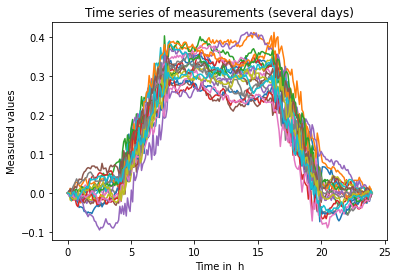

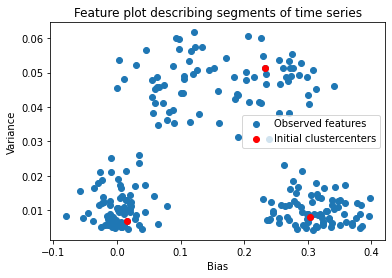

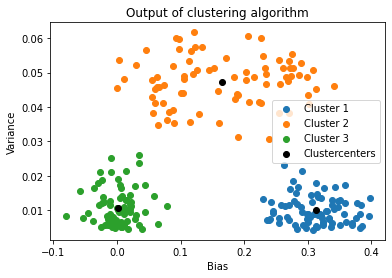

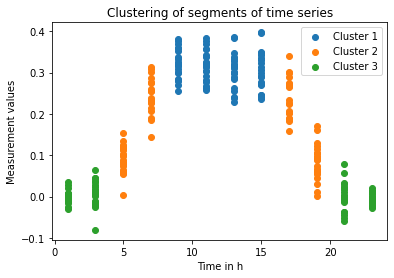

In [8]:

# Figure 1 showing sample time series of measurements from several days
plt.figure(1)
plt.plot(time_plot,Delta_d_measured)
plt.title('Time series of measurements (several days)')
plt.xlabel('Time in  h')
plt.ylabel('Measured values')

# Figure 2 showing bias and variance of segments of the time series. Bias is 
# calculated as average deviation from 0. n_aggregation measurements form a segment.
plt.figure(2)
plt.scatter(bias,variance)
plt.scatter(initial_clustercenters_unwhitened[0,:],initial_clustercenters_unwhitened[1,:],c='r')
plt.title('Feature plot describing segments of time series')
plt.xlabel('Bias')
plt.ylabel('Variance')
plt.legend(['Observed features','Initial clustercenters'])

# Figure 3 showing the output of the clustering algorithm. Points of different
# colors are associated to different clusters. The black dots are the clustercenters.
plt.figure(3)
for k in range(n_clusters):
    plt.scatter(bv_mat_unwhitened[0,classes==k],bv_mat_unwhitened[1,classes==k])
plt.scatter(Centers_unwhitened[0,:],Centers_unwhitened[1,:],c='k')
plt.title('Output of clustering algorithm')
plt.xlabel('Bias')
plt.ylabel('Variance')
legend_3=[]
for k in range(n_clusters):
    legend_3.append('Cluster %d' % int(k+1))
legend_3.append('Clustercenters')
plt.legend(legend_3)

# Figure 4 showing into which cluster each segment of the several time series
# is grouped. Note that the different stochastic behavior at different times of 
# day is reflected in the clustering.
plt.figure(4)
for k in range(n_clusters):
    plt.scatter(time_datapoint[classes==k],bv_mat_unwhitened[0,classes==k])
plt.title('Clustering of segments of time series')
plt.xlabel('Time in h')
plt.ylabel('Measurement values')
legend_4=[]
for k in range(n_clusters):
    legend_4.append('Cluster %d' % int(k+1))
plt.legend(legend_4)